# Loading Libraries

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio

In [2]:
from matplotlib import pyplot as plt

In [3]:
from skimage.filters import threshold_otsu

In [4]:
import seaborn as sns
sns.set_style("darkgrid")

# Utility Functions

In [5]:
def load_data(path):
    """ X = Images and Y = masks """

    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    mask_x =  sorted(glob(os.path.join(path, "training", "mask", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))
    return (train_x, mask_x,train_y)

In [6]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
def adjust_gamma(image, gamma=1.0):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

In [8]:
def adjust_square(image, gamma=1.0):
    table = np.array([[i**2 for i in row] for row in image]).astype("uint16")
    return table

In [9]:
def square_rescale(image):
    table = np.array([[i//(256) for i in row] for row in image]).astype("uint16")
    return table

# Loading The Data Set

In [10]:
""" Seeding """
np.random.seed(42)

""" Load the data """
data_path = "D:\\Data sets\\DRIVE"
(train_x, mask_x, train_y) = load_data(data_path)

print(f"Train: {len(train_x)} - {len(train_y)} - {len(mask_x)}")


Train: 20 - 20 - 20


# Square Transformation

In [12]:
x = train_x[0]
y = train_y[0]
m = mask_x[0]
""" Reading image and mask """
src = cv2.imread(x, cv2.IMREAD_COLOR)
mask  = cv2.imread(m, cv2.IMREAD_COLOR)
y = imageio.mimread(y)[0]

x = src[:,:,1]
m = mask[:,:,1]


<AxesSubplot:ylabel='Count'>

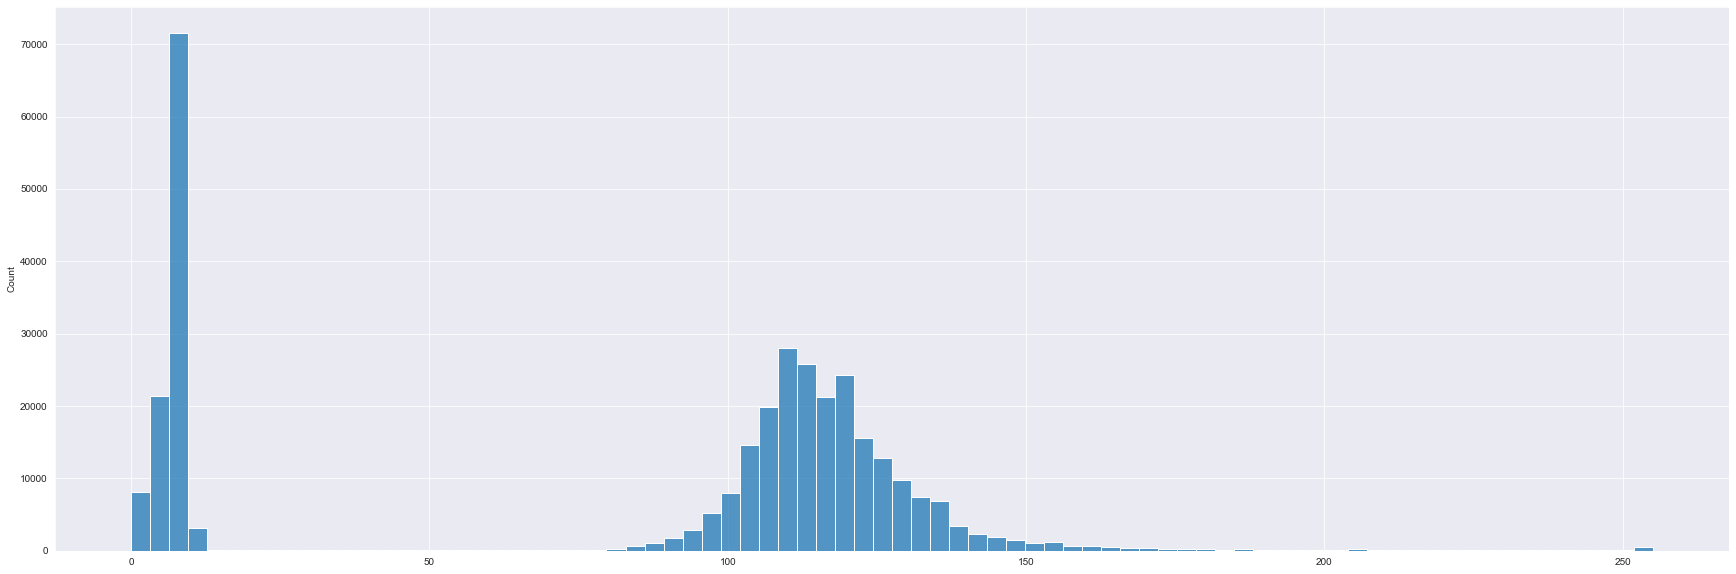

In [13]:
plt.figure(figsize=(30,10))
sns.histplot(data= x.ravel())

Thresh: 28


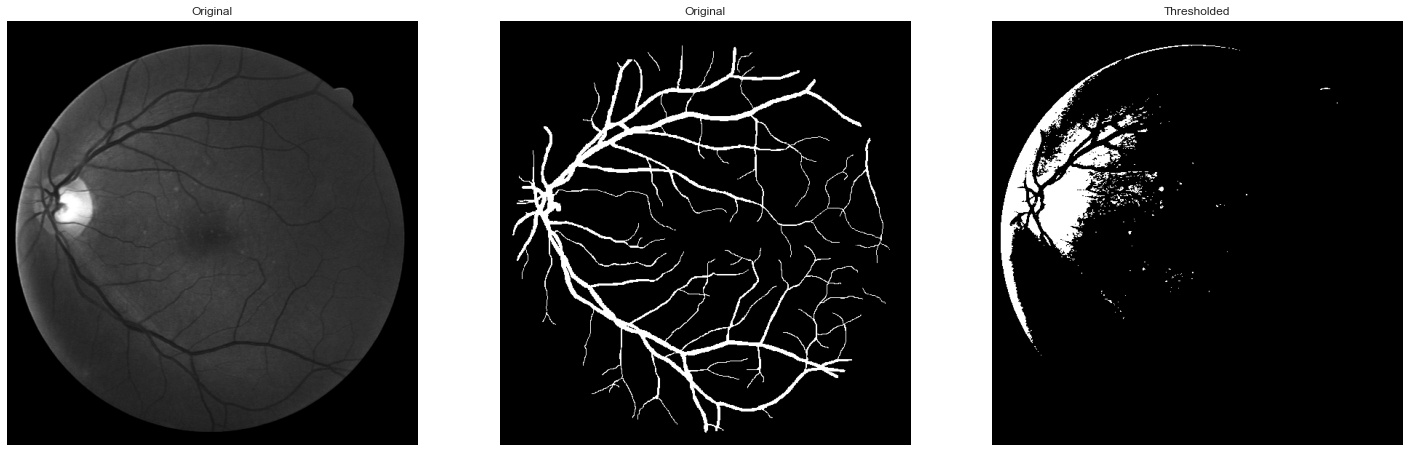

In [59]:
g = adjust_square(x, gamma=0.6)
h = square_rescale(g)        

thresh = threshold_otsu(h)
print("Thresh:",thresh)
#thresh = 4700
binary = h > (49 + 49*(1/2))

fig, axes = plt.subplots(ncols=3, figsize=(25, 25))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(h, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(y, cmap=plt.cm.gray)
ax[1].set_title('Original')
ax[1].axis('off')
ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()


In [116]:
h

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [23]:
image = cv2.GaussianBlur(h, (5, 5), 0)

In [43]:
# Set total number of bins in the histogram
bins_num = 256

# Get the image histogram
hist, bin_edges = np.histogram(image, bins=bins_num)

# Get normalized histogram if it is required

hist = np.divide(hist.ravel(), hist.max())


In [45]:
hist

array([1.00000000e+00, 6.71569881e-03, 4.07071641e-03, 2.58598651e-03,
       2.08452145e-03, 1.85837053e-03, 1.60272168e-03, 1.89770113e-03,
       1.19958310e-03, 1.27824428e-03, 1.30774223e-03, 9.93097481e-04,
       1.12092191e-03, 1.06192602e-03, 1.04226072e-03, 9.43934239e-04,
       7.57113921e-04, 1.00293013e-03, 9.83264833e-04, 9.34101591e-04,
       7.86611866e-04, 1.02259543e-03, 1.05209337e-03, 7.66946569e-04,
       8.65273053e-04, 1.00293013e-03, 1.04226072e-03, 1.15041985e-03,
       1.39623606e-03, 2.13368469e-03, 3.01862304e-03, 5.65377279e-03,
       7.72846158e-03, 9.21319148e-03, 1.14747006e-02, 1.54569232e-02,
       1.80527423e-02, 2.64498240e-02, 3.37259838e-02, 3.54761952e-02,
       3.63513009e-02, 3.87504671e-02, 4.29785058e-02, 5.27128277e-02,
       6.83762365e-02, 9.24957228e-02, 1.14039055e-01, 1.23635720e-01,
       1.18050776e-01, 1.05081513e-01, 9.40591139e-02, 8.52293957e-02,
       7.07262394e-02, 6.48168178e-02, 6.48168178e-02, 6.19948477e-02,
      

In [48]:
hist.min(),np.min(hist[np.nonzero(hist)])

(0.0, 4.9163241627499954e-05)

In [49]:
hist[0] = np.min(hist[np.nonzero(hist)])


In [50]:

# Calculate centers of bins
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

# Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

# Get the class means mu0(t)
mean1 = np.cumsum(hist * bin_mids) / weight1
# Get the class means mu1(t)
mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

# Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)

threshold = bin_mids[:-1][index_of_max_val]
print("Otsu's algorithm implementation thresholding result: ", threshold)

Otsu's algorithm implementation thresholding result:  115.58984375


In [15]:
m1  = cv2.bitwise_not(m)
mask_out=cv2.add(m1,h, dtype=cv2.CV_32F)
#mask_out=cv2.subtract(m,mask_out, dtype=cv2.CV_32F)

Thresh: 153.07617


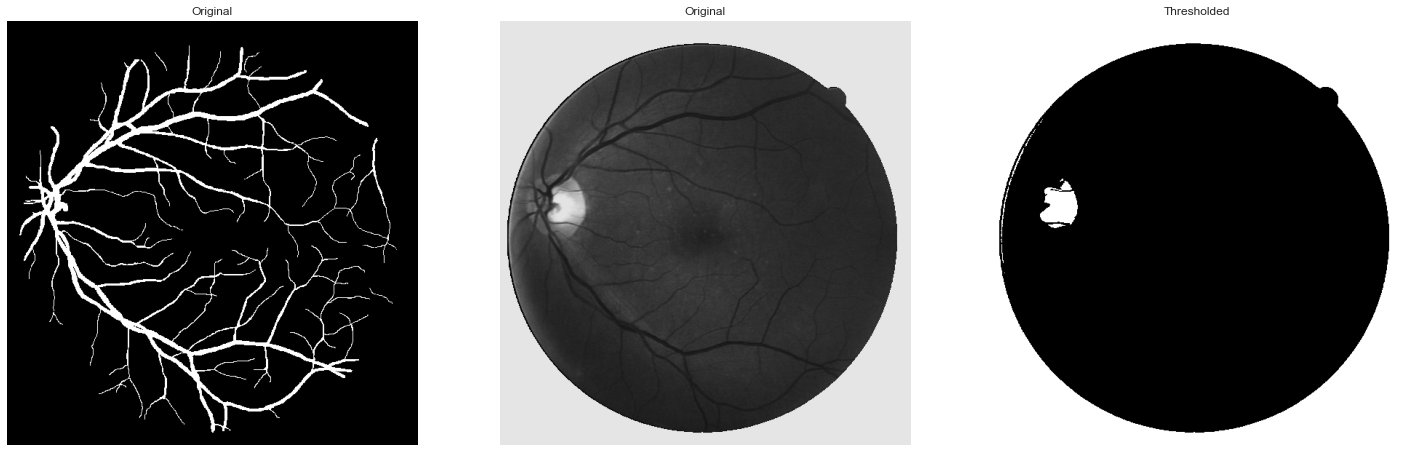

In [18]:
thresh = threshold_otsu(mask_out)
print("Thresh:",thresh)
#thresh = 4700
binary = mask_out > thresh

fig, axes = plt.subplots(ncols=3, figsize=(25, 25))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(y, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(mask_out, cmap=plt.cm.gray)
ax[1].set_title('Original')
ax[1].axis('off')
ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

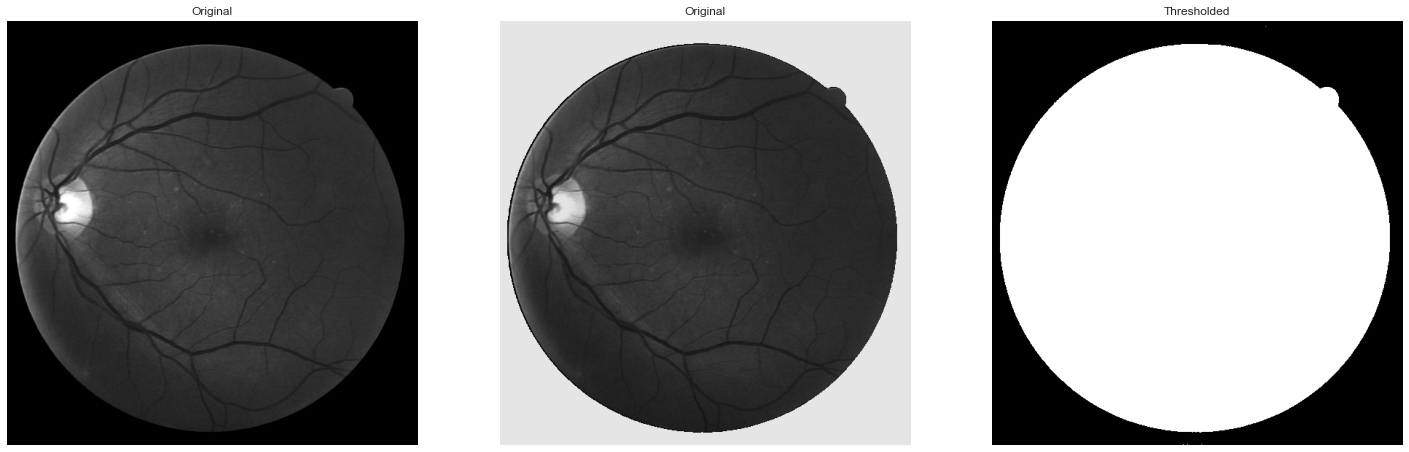

In [21]:
binary = h > 0.08609375

fig, axes = plt.subplots(ncols=3, figsize=(25, 25))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(h, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(mask_out, cmap=plt.cm.gray)
ax[1].set_title('Original')
ax[1].axis('off')
ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

In [102]:
(153.07617 + 28)/2

90.538085

<AxesSubplot:ylabel='Count'>

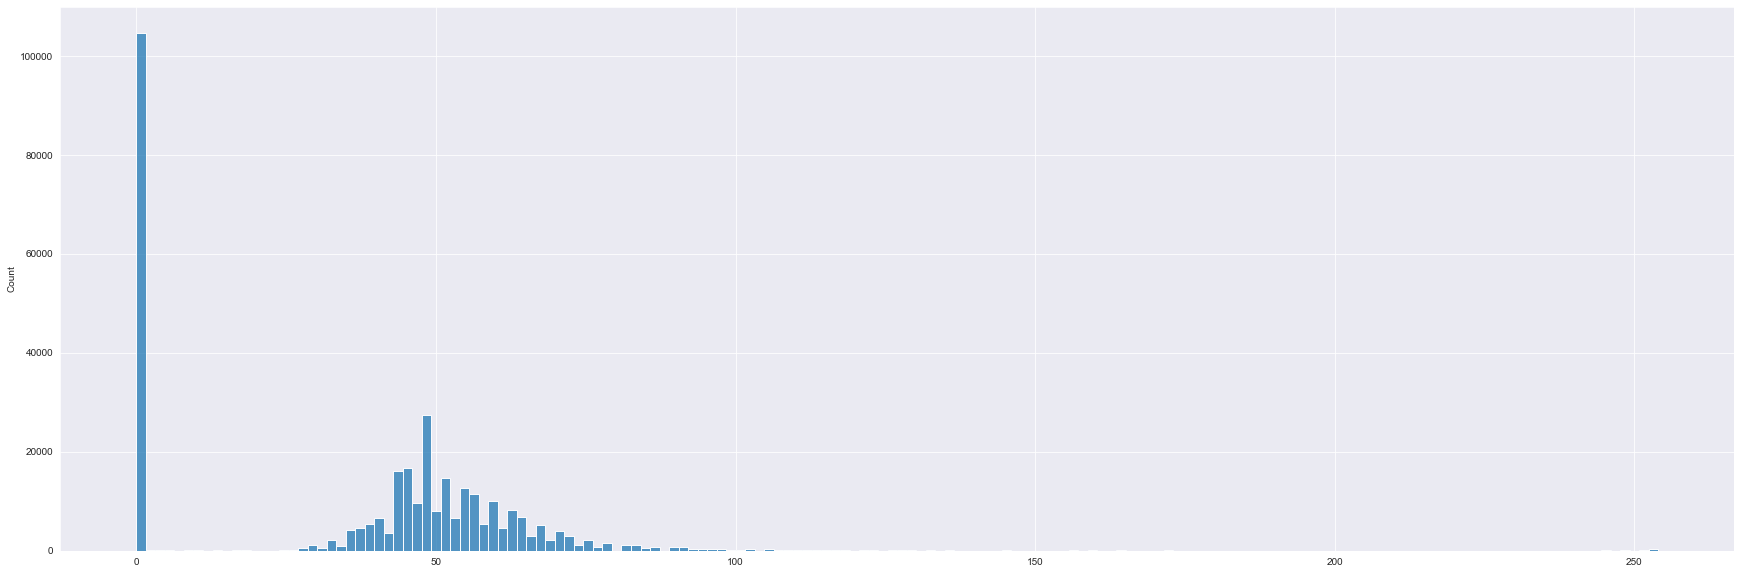

In [15]:
plt.figure(figsize=(30,10))
sns.histplot(data= h.ravel())

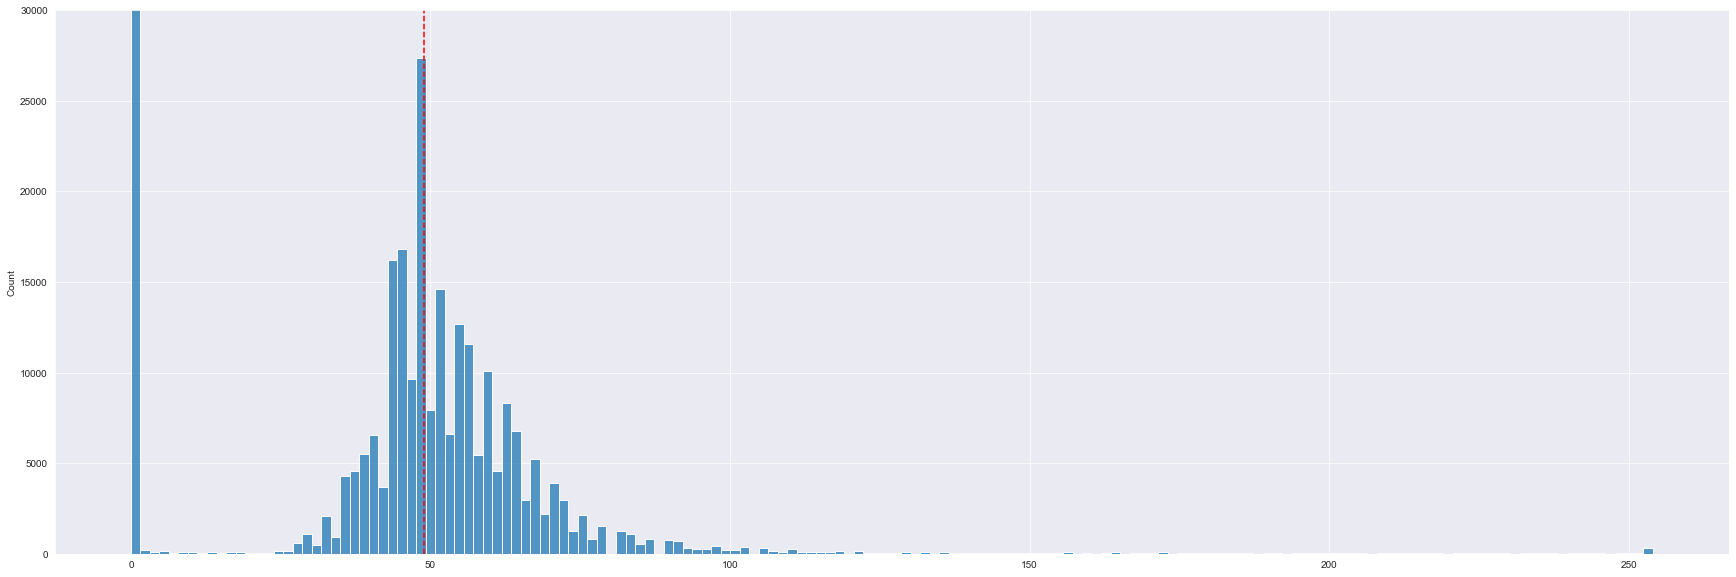

In [52]:
plt.figure(figsize=(30,10))
fig = sns.histplot(data= h.ravel())
fig.set(ylim=(0, 30000))
#fig.set(xlim=(0, 60000))
fig.axvline(49, ls='--', c='red')